T. Tarantola, D. Kumaran, P. Dayan, & B. De Martino. (in press) Prior preferences beneficially influence social and non-social learning. Nature Communications.

Modified by Naeun Oh & SeongJae Park

Notebook for Performance Simulations

#Performance simulations

In [402]:
import numpy as np
import pandas as pd
import math
import scipy.misc
import pystan
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import pylab as pl
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [403]:
# def softmax(beta, a, b=0): # Beta = exploration parameter; a = value of modeled choice
#     e = np.exp(beta*a)
#     e_alt = np.exp(beta*b)
#     prob = e / (e + e_alt)
#     return prob

def softmax(x):
    e = np.exp(x)
    e_alt = np.exp(0)
    prob = e / (e + e_alt)
    return prob

def prob(prior,n,x,p=0.8):  
    """
    Bayes's rule for the binomial distribution
    prior is the initial prior
    n is the number of feedback boxes seen so far for this item pair (current trial minus 1)
    x is the number of correct feedback boxes seen so far for this item pair
    """
    q = 1-p
    n_fac = scipy.special.factorial(n) # n!
    x_fac = scipy.special.factorial(x) # x!
    n_minus_x_fac = scipy.special.factorial((n-x)) # (n-x)!
    P_data_correct = ((n_fac)/(x_fac * n_minus_x_fac))*(p**x)*(q**(n-x)) # Probability of x successes if correct answer is assumed to be correct
    P_data_wrong = ((n_fac)/(x_fac * n_minus_x_fac))*(q**x)*(p**(n-x)) # Probability of x successes if wrong answer is assumed to be correct; just switched p and q
    P_correct_data = (P_data_correct * prior)/( (P_data_correct * prior) + (P_data_wrong * (1-prior)) )
    return P_correct_data

def correct_prob(p_corr, a, z, drift_weight):
    prob = np.empty(shape=p_corr.shape)
    v = drift_weight*((2*p_corr) - 1)
    
    prob[np.where(v==0)] = z[np.where(v==0)]
    prob[np.where(v!=0)] = 1 - ( (1 - np.exp(-2*v[np.where(v!=0)]*a*(1-z[np.where(v!=0)])) ) / (np.exp(2*v[np.where(v!=0)]*a*z[np.where(v!=0)]) - np.exp(-2*v[np.where(v!=0)]*a*(1-z[np.where(v!=0)])) ) )
    return prob

#Preference match matrix

##Actual preference data

In [404]:
data = pd.read_pickle('../data/social/data_processed_social_wexclusions.pkl')
control_data = pd.read_pickle('../data/non_social/data_processed_non_social_wexclusions.pkl')
# Concatenate social and control data sets
tojoin = [data,control_data]
data_combined = pd.concat(tojoin)

In [405]:
# Create a dataframe to hold a tally of preferred items
# A separate tally set is recorded for each participant, so that the participant's own preference is not recorded in the tally corresponding to them
data = data[data['block_loop_thisN'].notnull() & data['img_correct'].notnull()]
items = data_items.img_correct.unique()
items = items[:20]

In [406]:
prefs = pd.DataFrame(items, columns=['item'])
for i in items:
    prefs.loc[(prefs.item==i),'other_item'] = data_items.loc[(data_items.choice_left==i)].choice_right.values[0]

In [407]:
def extract_dv_first(participant):
    dv = np.empty((20))
    for i in range(0,len(prefs.item)):
        item = prefs.item[i]
        other_item = prefs.other_item[i]
        dv[i] = data_combined.loc[((data_combined.participant==participant)&(data_combined.bdm_img==item)),'bdm_bid1_response'].values[0] - data_combined.loc[((data_combined.participant==participant)&(data_combined.bdm_img==other_item)),'bdm_bid1_response'].values[0] 
    return dv

In [408]:
dv_first_list = np.empty((61,20))
for p in range(0,len(data_combined.participant.unique())):
    dv_first_list[p,:] = extract_dv_first(data_combined.participant.unique()[p])

In [409]:
def extract_dv_correct(participant, target):
    p_dv = dv_first_list[participant,:]
    target_dv = dv_first_list[target,:]
    dv_correct = np.empty(20)
    for i in range(20):
        if target_dv[i]==0: # If the target showed no preference, choose one at random
            dv_correct[i] = (np.random.choice([-1,1]))*p_dv[i]
        elif target_dv[i] <0:
            dv_correct[i] = -p_dv[i]
        elif target_dv[i] >0:
            dv_correct[i] = p_dv[i]
    
    return dv_correct

In [410]:
dv_correct_all_matches = np.empty((61*60,20))
for p in range(61):
    it = 0
    for i in [x for x in range(61) if x !=p]:
        dv_correct_all_matches[(p*60 + it), :] = extract_dv_correct(p, i)
        it += 1

#Get item_popularity 
#We Made This Code

In [412]:
data_wpop = pd.read_pickle(r'../data/social/data_processed_social_wexclusions_wpopularity.pkl')
control_data_wpop = pd.read_pickle(r'../data/non_social/data_processed_non_social_wexclusions_wpopularity.pkl')
tojoin_wpop = [data_wpop,control_data_wpop]
data_wpop_combined = pd.concat(tojoin_wpop)
data_wpop_combined = data_wpop_combined[data_wpop_combined['block_loop_thisN'].notnull() & data_wpop_combined['img_correct'].notnull()]

In [413]:
def extract_item_popularity_left(participant):
    pop_left = np.empty((20))
    for i in range(0,len(prefs.item)):
        item = prefs.item[i]
        other_item = prefs.other_item[i]
        if item in data_wpop_combined.loc[data_wpop_combined.participant==participant,'img_correct'].unique():
            pop_left[i] = data_wpop_combined.loc[((data_wpop_combined.participant==participant)&(data_wpop_combined.img_correct==item)),'ratio_prefer_correct'].values[0]
        else:
            pop_left[i] = data_wpop_combined.loc[((data_wpop_combined.participant==participant)&(data_wpop_combined.img_correct==other_item)),'ratio_prefer_wrong'].values[0] 
    return pop_left

def extract_item_popularity_right(participant):
    pop_right = np.empty((20))
    for i in range(0,len(prefs.item)):
        item = prefs.item[i]
        other_item = prefs.other_item[i]
        if other_item in data_wpop_combined.loc[data_wpop_combined.participant==participant,'img_correct'].unique():
            pop_right[i] = data_wpop_combined.loc[((data_wpop_combined.participant==participant)&(data_wpop_combined.img_correct==other_item)),'ratio_prefer_correct'].values[0]
        else:
            pop_right[i] = data_wpop_combined.loc[((data_wpop_combined.participant==participant)&(data_wpop_combined.img_correct==item)),'ratio_prefer_wrong'].values[0] 
    return pop_right

In [414]:
item_popularity_left = np.empty((61,20))
for p in range(0,len(data_combined.participant.unique())):
    item_popularity_left[p,:] = extract_item_popularity_left(data_combined.participant.unique()[p])
item_popularity_right = np.empty((61,20))
for p in range(0,len(data_combined.participant.unique())):
    item_popularity_right[p,:] = extract_item_popularity_right(data_combined.participant.unique()[p])

In [415]:
def extract_item_popularity_correct(participant, target):
    target_dv = dv_first_list[target,:]
    pop_correct = np.empty(20)
    for i in range(20):
        if target_dv[i]==0: # If the target showed no preference, choose one at random
            pop_correct[i] = (np.random.choice([item_popularity_right[participant,i],item_popularity_left[participant,i]]))
        elif target_dv[i] <0:
            pop_correct[i] = item_popularity_right[participant,i]
        elif target_dv[i] >0:
            pop_correct[i] = item_popularity_left[participant,i]
    
    return pop_correct

In [416]:
item_popularity_correct_all_matches = np.empty((61*60,20))
for p in range(61):
    it = 0
    for i in [x for x in range(61) if x !=p]:
        item_popularity_correct_all_matches[(p*60 + it), :] = extract_item_popularity_correct(p,i)
        it += 1

#Simulation code

In [419]:
def simulate(itr, dv_correct, drift_weight, learning_prior_temp, choice_bias_temp, threshold, popularity_prior_temp, popularity_bias_temp, item_popularity):
    """
    Simulate learning another person's preferences with the mean of the group means of the estimated parameters from
    the specified model

    This function simulates a single participant learning the choices made by a single target
    (20 items with 30 trials each), repeated a certain number of times ('itr') to allow for stochasticity in the
    feedback that is presented

    itr = the number of times each item is learned in the simulation
    dv_correct = the preference congruence, based on bids, for the choices being learned
    drift_weight = the mean of the group mean drift weight parameter from the chosen model
        learning_prior_temp = the mean of the group mean inverse temperature parameter used to convert DV into the 
        prior for the Bayesian inference
    choice_bias_temp = the mean of the group mean inverse temperature parameter used to convert DV into the
        bias term in the drift process
    threshold = the mean of the group mean drift threshold
    popularity_prior_temp = the mean of the group mean inverse temperature parameter used to convert item_popularity into the
        prior for the Bayesian inference
    popularity_bias_temp = the mean of the group mean inverse temperature parameter used to convert item_popularity into the
        bias term in the drift process
    item_popularity = the item_popularity, based on the ratio of other people who bidded more for item being learned
    """

    # Generate array of learning priors (item x iteration)
    learning_priors = softmax((learning_prior_temp*dv_correct)+(popularity_prior_temp*(item_popularity-0.5)))
    learning_priors = np.expand_dims(learning_priors, axis=1)
    learning_priors = np.repeat(learning_priors, itr, axis=1)
    learning_priors_expanded = np.expand_dims(learning_priors, axis=1)
    learning_priors_expanded = np.repeat(learning_priors_expanded, 29, axis=1)

    # Generate array of choice biases (item x iteration)
    choice_biases = softmax((choice_bias_temp*dv_correct)+(popularity_bias_temp*(item_popularity-0.5)))
    choice_biases = np.expand_dims(choice_biases, axis=1)
    choice_biases = np.repeat(choice_biases, itr, axis=1)
    choice_biases_expanded = np.expand_dims(choice_biases, axis=1)
    choice_biases_expanded = np.repeat(choice_biases_expanded, 30, axis=1)

    # Generate feedback (item x feedback-pertinent trial x iteration)
    feedback = np.random.choice([0,1], size=(20,29,itr), p=[0.2,0.8]) 
    feedback_cumulative = np.cumsum(feedback, axis=1)

    # Generate list of trial numbers to use for the binomial calculation (item x trial x iteration)
    trial_numbers = np.expand_dims(np.arange(0,30), axis=1)
    trial_numbers = np.repeat(trial_numbers, itr, axis=1)
    trial_numbers_expanded = np.expand_dims(trial_numbers, axis=0)
    trial_numbers_expanded = np.repeat(trial_numbers_expanded, 20, axis=0)

    # Calculate Bayesian probabilities of correct item being correct
    bayes_probs = np.empty((20,30,itr))
    bayes_probs[:,0,:] = learning_priors
    bayes_probs[:,1:,:] = prob(learning_priors_expanded, trial_numbers_expanded[:,1:,:], feedback_cumulative)

    # Calculate probabilities of correct responses
    response_correct = np.empty((20,30,itr))
    response_correct = correct_prob(bayes_probs, threshold, choice_biases_expanded, drift_weight)

    response_correct_means = np.mean(response_correct, axis=(0,2))
    
    return response_correct_means

In [420]:
def simulate_null(itr, drift_weight, threshold):

    # Generate array of learning priors (item x iteration)
    learning_priors = np.empty(20)
    learning_priors.fill(0.5)

    learning_priors = np.expand_dims(learning_priors, axis=1)
    learning_priors = np.repeat(learning_priors, itr, axis=1)
    learning_priors_expanded = np.expand_dims(learning_priors, axis=1)
    learning_priors_expanded = np.repeat(learning_priors_expanded, 29, axis=1)

    # Generate array of choice biases (item x iteration)
    choice_biases = np.empty(20)
    choice_biases.fill(0.5)

    choice_biases = np.expand_dims(choice_biases, axis=1)
    choice_biases = np.repeat(choice_biases, itr, axis=1)
    choice_biases_expanded = np.expand_dims(choice_biases, axis=1)
    choice_biases_expanded = np.repeat(choice_biases_expanded, 30, axis=1)

    # Generate feedback (item x feedback-pertinent trial x iteration)
    feedback = np.random.choice([0,1], size=(20,29,itr), p=[0.2,0.8]) 
    feedback_cumulative = np.cumsum(feedback, axis=1)

    # Generate list of trial numbers to use for the binomial calculation (item x trial x iteration)
    trial_numbers = np.expand_dims(np.arange(0,30), axis=1)
    trial_numbers = np.repeat(trial_numbers, itr, axis=1)
    trial_numbers_expanded = np.expand_dims(trial_numbers, axis=0)
    trial_numbers_expanded = np.repeat(trial_numbers_expanded, 20, axis=0)

    # Calculate Bayesian probabilities of correct item being correct
    bayes_probs = np.empty((20,30,itr))
    bayes_probs[:,0,:] = learning_priors
    bayes_probs[:,1:,:] = prob(learning_priors_expanded, trial_numbers_expanded[:,1:,:], feedback_cumulative)

    # Calculate probabilities of correct responses
    response_correct = np.empty((20,30,itr))
    response_correct = correct_prob(bayes_probs, threshold, choice_biases_expanded, drift_weight)

    response_correct_means = np.mean(response_correct, axis=(0,2))
    
    return response_correct_means

In [436]:
def simulate_dual(itr, dv_correct, drift_weight, learning_prior_temp, choice_bias_temp, threshold, ):

    # Generate array of learning priors (item x iteration)

    learning_priors = softmax(learning_prior_temp*dv_correct)
    learning_priors = np.expand_dims(learning_priors, axis=1)
    learning_priors = np.repeat(learning_priors, itr, axis=1)
    learning_priors_expanded = np.expand_dims(learning_priors, axis=1)
    learning_priors_expanded = np.repeat(learning_priors_expanded, 29, axis=1)

    # Generate array of choice biases (item x iteration)

    choice_biases = softmax(choice_bias_temp*dv_correct)
    choice_biases = np.expand_dims(choice_biases, axis=1)
    choice_biases = np.repeat(choice_biases, itr, axis=1)
    choice_biases_expanded = np.expand_dims(choice_biases, axis=1)
    choice_biases_expanded = np.repeat(choice_biases_expanded, 30, axis=1)

    # Generate feedback (item x feedback-pertinent trial x iteration)
    feedback = np.random.choice([0,1], size=(20,29,itr), p=[0.2,0.8]) 
    feedback_cumulative = np.cumsum(feedback, axis=1)

    # Generate list of trial numbers to use for the binomial calculation (item x trial x iteration)
    trial_numbers = np.expand_dims(np.arange(0,30), axis=1)
    trial_numbers = np.repeat(trial_numbers, itr, axis=1)
    trial_numbers_expanded = np.expand_dims(trial_numbers, axis=0)
    trial_numbers_expanded = np.repeat(trial_numbers_expanded, 20, axis=0)

    # Calculate Bayesian probabilities of correct item being correct
    bayes_probs = np.empty((20,30,itr))
    bayes_probs[:,0,:] = learning_priors
    bayes_probs[:,1:,:] = prob(learning_priors_expanded, trial_numbers_expanded[:,1:,:], feedback_cumulative)

    # Calculate probabilities of correct responses
    response_correct = np.empty((20,30,itr))
    response_correct = correct_prob(bayes_probs, threshold, choice_biases_expanded, drift_weight)

    response_correct_means = np.mean(response_correct, axis=(0,2))
    
    return response_correct_means

#Simulate estimated models

In [421]:
# means of group mean parameters from dual influence + pop_dual_influenced
drift_weight = 1.85814825e+00
learning_prior_temp = 3.12479250e-01
choice_bias_temp = 1.70402441e-01
threshold = 2.13136058e+00
popularity_prior_temp = 7.04640520e-02
popularity_bias_temp = -7.16883805e-02

Note that the simulations below use the parameter estimates from the dual influence+popularity_dual_influenced model, replacing them with neutral alternatives where necessary, for a fairer comparison. This is because we want to compare not the fits of the alternative models, but what performance would look like if the parameters of the best-fitting model were replaced with unbiased alternatives.

##Run simulations

In [ ]:
# Load pickles if already saved
null_simulation = np.load('simulation_pickles/null_simulation.npy')
null_simulation_mean = np.mean(null_simulation, axis=0)

dual_simulation = np.load('simulation_pickles/dual_simulation.npy')
dual_simulation_mean = np.mean(dual_simulation, axis=0)

pop_choice_simulation = np.load('simulation_pickles/pop_choice_simulation.npy')
pop_choice_simulation_mean = np.mean(pop_choice_simulation, axis=0)

pop_prior_simulation = np.load('simulation_pickles/pop_prior_simulation.npy')
pop_prior_simulation_mean = np.mean(pop_prior_simulation, axis=0)

pop_dual_simulation = np.load('simulation_pickles/pop_dual_simulation.npy')
pop_dual_simulation_mean = np.mean(pop_dual_simulation, axis=0)

In [441]:
# Neutral
null_simulation = np.empty((3660,30))
for i in range(3660):
    null_simulation[i,:] = simulate_null(1000,drift_weight,threshold)
null_simulation_mean = np.mean(null_simulation, axis=0)
np.save('simulation_pickles/null_simulation.npy', null_simulation)
print ('Done neutral')

Done neutral


In [442]:
# Dual influence
dual_simulation = np.empty((3660,30))
for i in range(3660):
    dual_simulation[i,:] = simulate_dual(1000, dv_correct_all_matches[i], drift_weight, learning_prior_temp,
                                    choice_bias_temp, threshold)
dual_simulation_mean = np.mean(dual_simulation, axis=0)
np.save('simulation_pickles/dual_simulation.npy', dual_simulation)
print ('Done dual')

Done dual


In [521]:
# Dual influence + pop_influenced_choice
pop_choice_simulation = np.empty((3660,30))
for i in range(3660):
    pop_choice_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], drift_weight, learning_prior_temp,
                                    choice_bias_temp, threshold, 0, popularity_bias_temp , item_popularity_correct_all_matches[i])
pop_choice_simulation_mean = np.mean(pop_choice_simulation, axis=0)
np.save('simulation_pickles/pop_choice_simulation.npy', pop_choice_simulation)
print ('Done pop_choice')

Done pop_choice


In [522]:
# Dual influence + pop_influenced_prior
pop_prior_simulation = np.empty((3660,30))
for i in range(3660):
    pop_prior_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], drift_weight, learning_prior_temp,
                                    choice_bias_temp, threshold, popularity_prior_temp, 0 , item_popularity_correct_all_matches[i])
pop_prior_simulation_mean = np.mean(pop_prior_simulation, axis=0)
np.save('simulation_pickles/pop_prior_simulation.npy', pop_prior_simulation)
print ('Done pop_prior')

Done pop_prior


In [460]:
# Dual influence + pop_dual_influenced
pop_dual_simulation = np.empty((3660,30))
for i in range(3660):
    pop_dual_simulation[i,:] = simulate(1000, dv_correct_all_matches[i], drift_weight, learning_prior_temp,
                                    choice_bias_temp, threshold, popularity_prior_temp, popularity_bias_temp , item_popularity_correct_all_matches[i])
pop_dual_simulation_mean = np.mean(pop_dual_simulation, axis=0)
np.save('simulation_pickles/pop_dual_simulation.npy', pop_dual_simulation)
print ('Done pop_dual')

Done pop_dual


In [531]:
print (np.sum(null_simulation_mean)*20, ((np.sum(null_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean)))
print (np.sum(dual_simulation_mean)*20, ((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean)))
print (np.sum(pop_choice_simulation_mean)*20, ((np.sum(pop_choice_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean)))
print (np.sum(pop_prior_simulation_mean)*20, ((np.sum(pop_prior_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean)))
print (np.sum(pop_dual_simulation_mean)*20, ((np.sum(pop_dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean)))
print ('')
print (((np.sum(dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600)
print (((np.sum(pop_choice_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600)
print (((np.sum(pop_prior_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600)
print (((np.sum(pop_dual_simulation_mean) - np.sum(null_simulation_mean)) / np.sum(null_simulation_mean))*600)

559.953740368672 0.0
561.7822704809325 0.0032655020949707045
561.5793954059035 0.002903195246380859
561.9023887349263 0.0034800166973994865
561.7101153009143 0.0031366429146198805

1.9593012569824226
1.7419171478285156
2.0880100184396917
1.8819857487719283


# Plot % point advantage of each model compared to null model

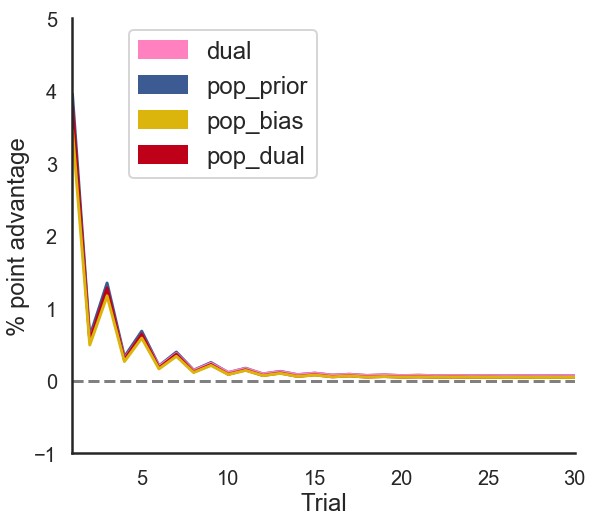

In [632]:


sns.set_context("poster")
sns.set_style("white", {"grid.linewidth": 0})
pl.rcParams['figure.figsize'] = (9.0, 8.0)
ax = plt.subplot()
plt.plot(range(1,31),(pop_prior_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['denim blue'], linewidth=3)
plt.plot(range(1,31),(dual_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['pink'], linewidth=3)
plt.plot(range(1,31),(pop_dual_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['scarlet'], linewidth=3)
plt.plot(range(1,31),(pop_choice_simulation_mean - null_simulation_mean)*100, color=sns.xkcd_rgb['gold'], linewidth=3)
plt.xlim((1,30))
plt.axhline(y=0, color='grey', linestyle='dashed')

plt.ylim((-1,5))
plt.ylabel('% point advantage', size=24)
plt.xlabel('Trial', size=24)

dual_patch = mpatches.Patch(color=sns.xkcd_rgb['pink'], label='dual')
pop_prior_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='pop_prior')
pop_bias_patch = mpatches.Patch(color=sns.xkcd_rgb['gold'], label='pop_bias')
pop_dual_patch = mpatches.Patch(color=sns.xkcd_rgb['scarlet'], label='pop_dual')
plt.tick_params(axis='both', which='both', labelsize=20)
plt.legend(handles=[dual_patch, pop_prior_patch, pop_bias_patch,pop_dual_patch], bbox_to_anchor=(0.3,1), loc=9, fontsize=24)
#plt.title('Actual Preference Data',size=34, position=[0.5,1.05])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/simulation_performance_advantages.svg')

# Plot % advantage of each model in the first, middle, and last 10 trials.

#calculate  % advantage of each model in the first, middle, and last 10 trials.

In [548]:
dual_advantage_last10 = (dual_simulation_mean - null_simulation_mean)[20:].mean()
print(dual_advantage_last10)
dual_advantage_mid10 = (dual_simulation_mean - null_simulation_mean)[10:20].mean()
print(dual_advantage_mid10)
dual_advantage_first10 = (dual_simulation_mean - null_simulation_mean)[:10].mean()
print(dual_advantage_first10)

0.0007058628259101529
0.0009785509945964277
0.007458236740796331


In [549]:
pop_choice_advantage_last10 = (pop_choice_simulation_mean - null_simulation_mean)[20:].mean()
print(pop_choice_advantage_last10)
pop_choice_advantage_mid10 = (pop_choice_simulation_mean - null_simulation_mean)[10:20].mean()
print(pop_choice_advantage_mid10)
pop_choice_advantage_first10 = (pop_choice_simulation_mean - null_simulation_mean)[:10].mean()
print(pop_choice_advantage_first10)

0.0004904070233699431
0.0007408891734639322
0.006896978989323977


In [550]:
pop_prior_advantage_last10 = (pop_prior_simulation_mean - null_simulation_mean)[20:].mean()
print(pop_prior_advantage_last10)
pop_prior_advantage_mid10 = (pop_prior_simulation_mean - null_simulation_mean)[10:20].mean()
print(pop_prior_advantage_mid10)
pop_prior_advantage_first10 = (pop_prior_simulation_mean - null_simulation_mean)[:10].mean()
print(pop_prior_advantage_first10)

0.0007057808963060408
0.0009858578381775507
0.008051603096788772


In [551]:
pop_dual_advantage_last10 = (pop_dual_simulation_mean - null_simulation_mean)[20:].mean()
print(pop_dual_advantage_last10)
pop_dual_advantage_mid10 = (pop_dual_simulation_mean - null_simulation_mean)[10:20].mean()
print(pop_dual_advantage_mid10)
pop_dual_advantage_first10 = (pop_dual_simulation_mean - null_simulation_mean)[:10].mean()
print(pop_dual_advantage_first10)

0.0004874965735226167
0.0007607206178583236
0.007533657469830779


C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


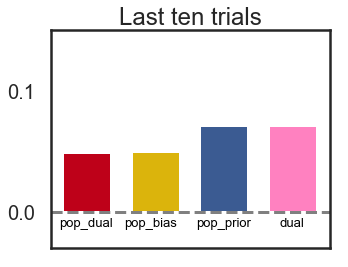

In [634]:
ax = plt.figure(figsize=(5,4))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(4),[pop_dual_advantage_last10*100, pop_choice_advantage_last10*100, pop_prior_advantage_last10*100, dual_advantage_last10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['pink']])
plt.ylim((-0.03,0.15))
plt.yticks([0,0.1])
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Last ten trials', size=24)
ax.text(0.15,0.2,'pop_dual', size=13, color='black')
ax.text(0.33,0.2,'pop_bias', size=13, color='black')
ax.text(0.53,0.2,'pop_prior', size=13, color='black')
ax.text(0.76,0.2,'dual', size=13, color='black')
plt.savefig('figures/simulation_performance_advantages_last10.svg', bbox_inches='tight')

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


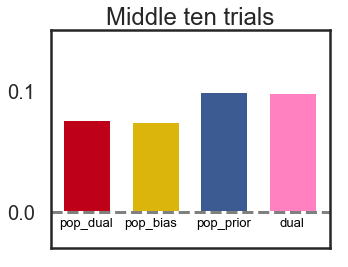

In [635]:
ax = plt.figure(figsize=(5,4))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(4),[pop_dual_advantage_mid10*100, pop_choice_advantage_mid10*100, pop_prior_advantage_mid10*100, dual_advantage_mid10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['pink']])
plt.ylim((-0.03,0.15))
plt.yticks([0,0.1])
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Middle ten trials', size=24)
ax.text(0.15,0.2,'pop_dual', size=13, color='black')
ax.text(0.33,0.2,'pop_bias', size=13, color='black')
ax.text(0.53,0.2,'pop_prior', size=13, color='black')
ax.text(0.76,0.2,'dual', size=13, color='black')
plt.savefig('figures/simulation_performance_advantages_mid10.svg', bbox_inches='tight')

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


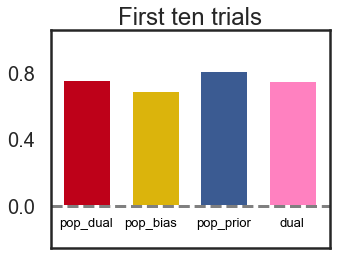

In [636]:
ax = plt.figure(figsize=(5,4))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.bar(range(4),[pop_dual_advantage_first10*100, pop_choice_advantage_first10*100, pop_prior_advantage_first10*100, dual_advantage_first10*100], width=0.7, align='center', color=[sns.xkcd_rgb['scarlet'],sns.xkcd_rgb['gold'],sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['pink']])
plt.ylim((-0.25,1.05))
plt.yticks([0, 0.4,0.8])
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('First ten trials', size=24)
ax.text(0.15,0.20,'pop_dual', size=13, color='black')
ax.text(0.33,0.20,'pop_bias', size=13, color='black')
ax.text(0.53,0.20,'pop_prior', size=13, color='black')
ax.text(0.76,0.20,'dual', size=13, color='black')
plt.savefig('figures/simulation_performance_advantages_first10.svg', bbox_inches='tight')